# Generate figures

The script below runs the model, outputs the results, and generates figures.

Last updated: 13 April 2020

## 1. Import ecohydro model

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
os.chdir('..')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture

## 2. Make figures

### Results figures

#### Figure 1.

Want to have soil moisture when dos > 1 and return average soil moisture 

Description: a) For the period that the crop is growing (dos > 0), for a specific soil type and specific climate (one that is representative of farmers in Kenya), then run many simulations (like in the 100s, not thousands) to represent number of farmers or fields in the study, like as if we’d put arable pods in all of those. Get the distribution of soil moisture values as if they’d all planted on the same day. I.e. many farmers, same, day, overall distribution of farmers. I think I can take the distribution of all the farmer values of soil moisture. 

b) Get the average distribution of that soil moisture for all the farmers. 

For some reason these are not double humped!

What's below is parts a and b of this figure.
Need to work on part c.

# Going to make all of this figures seperately and then can do proplot

Adding part c:

In [ ]:
def soil_moisture_pdf(n_sim = 500, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim # Because we want a date with little rainfall

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp
    
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Make figures: left is one of the simulations, right is the average
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), sharex=False)
    fig.suptitle('Average Soil Moisture PDF \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim, fontsize=15)

    axes[0].set_ylabel(r'p($s$)', fontsize=12)
    axes[1].set_ylabel(r'p($\bar{s}$)', fontsize=12)
    
    # plot the soil moisture for just one simulation
    num_of_sim = 0
    s_sim = output[0][start:end]['s']
    sns.distplot(s_sim, hist=False, kde=True, rug=False, ax=axes[0], label="lgp=%d" %lgp) # bins=None,
    
    sns.distplot(avg_s, hist=False, kde=True, rug=False, ax=axes[1], label="lgp=%d" %lgp) # bins=None,
    plt.xlabel('s')
    
    return int(lgp), avg_s, output, start, end, station, texture, pd_sim

lgp, avg_s, output, start, end, station, texture, pd_sim = soil_moisture_pdf()
#soil_moisture_pdf()


In [ ]:
# Plots c for Figure 1

# we want the avg s.m. of each day which is what I had before
avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
avg_daily_t = avg_daily.T
daily_mean = avg_daily.mean(axis=1)
    
plt.plot(daily_mean, 'k-', label="lgp=%d" %lgp) # bins=None, #ax=axes[1,0], 
plt.xlabel('s')

x = np.arange(0+21, len(daily_mean)+21, 1) 

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
plt.fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue') #, facecolor='lightsalmon'
plt.ylim(0.2, 0.9)
    
# Then figure 2

avg_s = [df[start:end]['stress'].mean() for df in output]
    
# Part 6. Make figures: left is one of the simulations, right is the average
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), sharex=False)
fig.suptitle('Average Stress PDF \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim, fontsize=15)

axes[0].set_ylabel(r'p($s$)', fontsize=12)
axes[1].set_ylabel(r'p($\bar{s}$)', fontsize=12)

# plot the soil moisture for just one simulation
num_of_sim = 0
s_sim = output[0][start:end]['stress']
sns.distplot(s_sim, hist=False, kde=True, rug=False, ax=axes[0], label="lgp=%d" %lgp) # bins=None,

sns.distplot(avg_s, hist=False, kde=True, rug=False, ax=axes[1], label="lgp=%d" %lgp) # bins=None,
plt.xlabel('s')


In [ ]:
# we want the avg stress of each day which is what I had before
avg_daily = pd.concat([df[start:end]['stress'] for df in output], axis=1)
avg_daily_t = avg_daily.T
daily_mean = avg_daily.mean(axis=1)
    
plt.plot(daily_mean, 'k-', label="lgp=%d" %lgp) # bins=None, #ax=axes[1,0], 
plt.xlabel('s')

x = np.arange(0+21, len(daily_mean)+21, 1) 

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
plt.fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue') #, facecolor='lightsalmon'
plt.ylim(-0.4, 0.9)

x

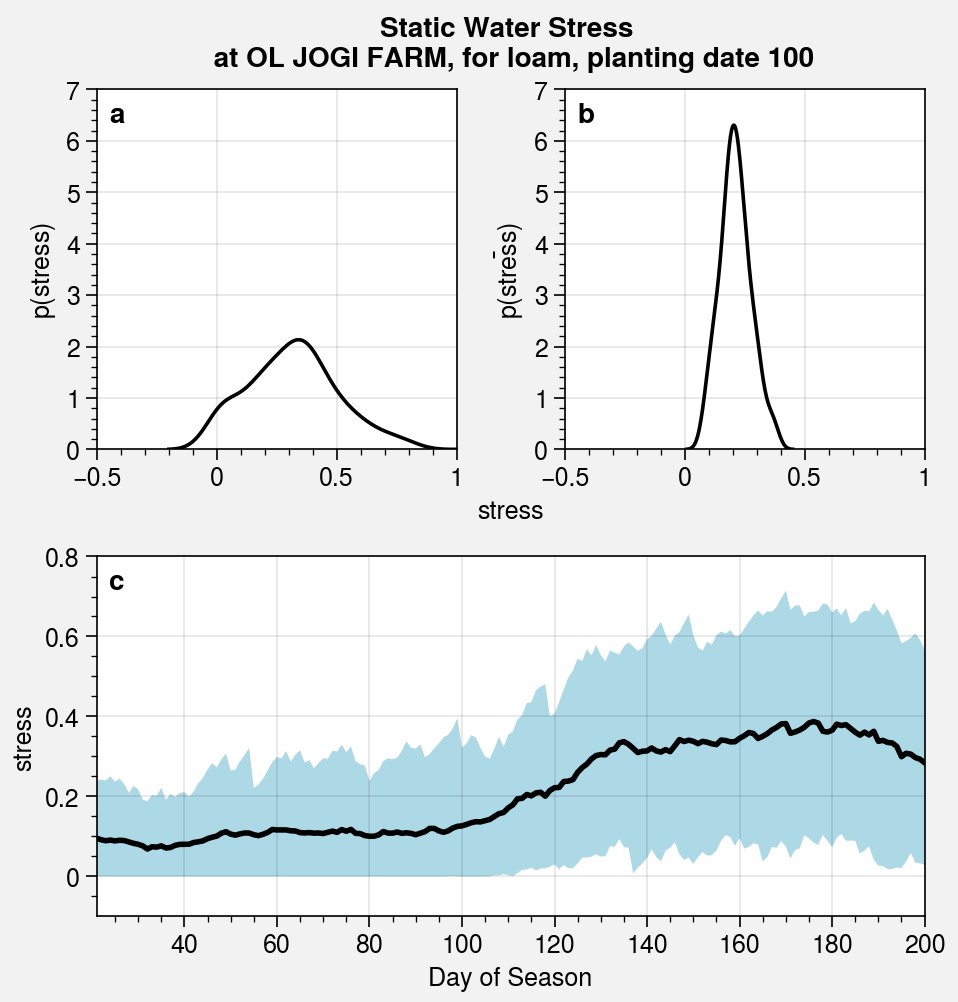

In [13]:
# using proplot

def static_stress_pdf(n_sim = 100, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim # Because we want a date with little rainfall

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp
    
    avg_s = [df[start:end]['stress'].mean() for df in output]
    
    # Part 6. Make figures: 
    # Complex grid
    array = [  # the "picture"; 1 == subplot a, 2 == subplot b, etc.
        [1, 1, 2, 2],
        [3, 3, 3, 3],
    ]
    f, axs = plot.subplots(array, axwidth=1.8, share=0, spanx=1, sharey=0)
    axs.format(
        abc=True, abcloc='ul', suptitle='Static Water Stress \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim,
        xlabel='stress', ylabel='ylabel'
    )

    axs[0,0].format(ylabel=r'p($stress$)')
    axs[0,1].format(ylabel=r'p($\bar{stress}$)')
    
    # plot the soil moisture for just one simulation
    num_of_sim = 0
    s_sim = output[0][start:end]['stress']
    data = np.array(s_sim)
    ax = axs[0]
    sns.distplot(data, ax=ax, color='k', **{'kde': True, 'hist': False}) # bins=None,, label="lgp=%d" %lgp
    ax.format(xlim=(-0.5, 1), ylim=(0, 7))
    
    # some extra code
    # this is useful for getting the average soil moisture for any given day or a range of days
    #day_of_sim = 10
    #s_day_10 = [df['s'][day_of_sim] for df in output]
    #pd.DataFrame(s_day_10).hist()
    
    #pd.DataFrame(avg_s).plot()
    #pd.DataFrame(avg_s).hist()
    ax = axs[1]
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': False}) # bins=None,
    ax.format(xlim=(-0.5, 1), ylim=(0, 7))
    
    # we want the avg s.m. of each day which is what I had before
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean = daily_mean
    
    axs[2].plot(daily_mean, color='k', lw=2) # bins=None, #ax=axes[1,0], label="lgp=%d" %lgp, 
    plt.xlabel('Day of Season')

    x = np.arange(0+21, len(daily_mean)+21, 1) 

    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[2].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue') #, facecolor='lightsalmon'
    plt.ylim(-0.1, 0.8)
    plt.ylabel('stress')
    
    return int(lgp), avg_s, output, start, end

lgp, avg_s, output, start, end = static_stress_pdf()


array([0.55841537, 0.56416708, 0.56280421, 0.56295334, 0.56408038,
       0.56888511, 0.56805785, 0.56682338, 0.56686177, 0.56309796,
       0.5638512 , 0.56446257, 0.56566127, 0.56717349, 0.56390506,
       0.56469749, 0.56397739, 0.5677732 , 0.5706571 , 0.57600033,
       0.57700177, 0.57383416, 0.57198127, 0.57585897, 0.57901095,
       0.57875445, 0.57796033, 0.57586306, 0.5777645 , 0.57617558,
       0.57474021, 0.5741692 , 0.57636056, 0.57693418, 0.57898484,
       0.57839844, 0.57844572, 0.58094682, 0.57867066, 0.57876603,
       0.58020306, 0.57985174, 0.57980924, 0.57826282, 0.57766288,
       0.57709262, 0.57392943, 0.57360213, 0.57407364, 0.57305659,
       0.57232536, 0.57076903, 0.56750742, 0.56522088, 0.56442675,
       0.56526703, 0.56870532, 0.56831574, 0.56689824, 0.56346564,
       0.56160447, 0.55752755, 0.5603253 , 0.56069649, 0.56207719,
       0.56200778, 0.55990503, 0.56108812, 0.55986907, 0.55672896,
       0.55587606, 0.5503756 , 0.55121305, 0.55105103, 0.54646

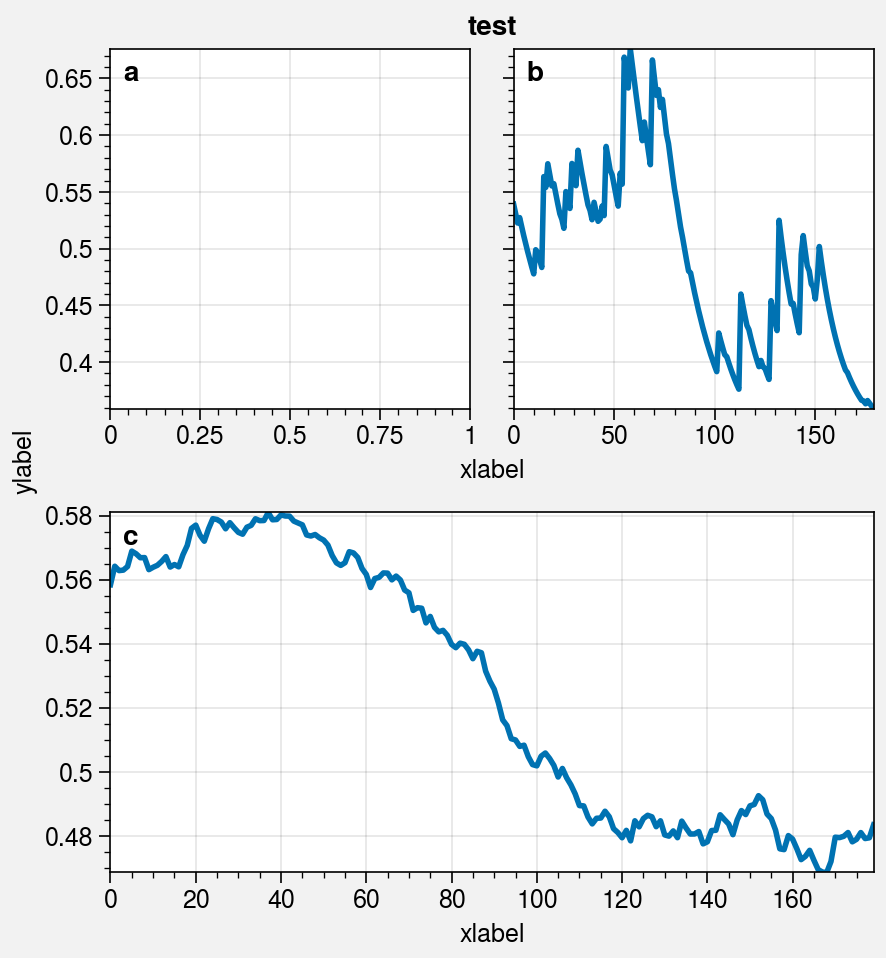

In [7]:
# what I learned: everything has to be an array
avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
avg_daily_t = avg_daily.T
daily_mean = avg_daily.mean(axis=1)

array = [  # the "picture"; 1 == subplot a, 2 == subplot b, etc.
        [1, 1, 2, 2],
        [3, 3, 3, 3],
    ]
f, axs = plot.subplots(array, axwidth=1.8)
axs.format(
    abc=True, abcloc='ul', suptitle='test',
    xlabel='xlabel', ylabel='ylabel'
    )
    
    
num_of_sim = 0
s_sim = output[0][start:end]['s']
data = np.array(s_sim)
axs[1].plot(data, lw=2)
#ax = axs[0]
#sns.distplot(s_sim, ax=ax, **{'kde': True, 'hist': False}) # bins=None,, label="lgp=%d" %lgp
    
    
state = np.random.RandomState(51423)
data = 2*(state.rand(100, 5) - 0.5).cumsum(axis=0)

#axs[0].plot(data, lw=2)
x = np.arange(0+21, len(daily_mean)+21, 1)
daily_mean = daily_mean
data = np.array(daily_mean)

axs[2].plot(data, lw=2)
data

In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns


import proplot as plot
import calendar

def drop_nans_and_flatten(dataArray: xr.DataArray) -> np.ndarray:
    """flatten the array and drop nans from that array. Useful for plotting histograms.

    Arguments:
    ---------
    : dataArray (xr.DataArray)
        the DataArray of your value you want to flatten
    """
    # drop NaNs and flatten
    return dataArray.values[~np.isnan(dataArray.values)]


# create dimensions of xarray object
times = pd.date_range(start='1981-01-31', end='2019-04-30', freq='M')
lat = np.linspace(0, 1, 224)
lon = np.linspace(0, 1, 176)

rand_arr = np.random.randn(len(times), len(lat), len(lon))

# create xr.Dataset
coords = {'time': times, 'lat':lat, 'lon':lon}
dims = ['time', 'lat', 'lon']
ds = xr.Dataset({'precip': (dims, rand_arr)}, coords=coords)
ds['month'], ds['year'] = ds['time.month'], ds['time.year']

f, axs = plot.subplots(nrows=4, ncols=3, axwidth=1.5, figsize=(8,12), share=2) # share=3, span=1,
axs.format(
    xlabel='Precip', ylabel='Density', suptitle='Distribution', 
)

month_abbrs = list(calendar.month_abbr)
mean_ds = ds.groupby('time.month').mean(dim='time')
flattened = []
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    ax.set_title(month_abbrs[mth])
    print(f"Plotting {month_abbrs[mth]}")
    flat = drop_nans_and_flatten(mean_ds.sel(month=mth).precip)
    flattened.append(flat)
    sns.distplot(flat, ax=ax, **{'kde': False})

In [ ]:
np.array(s_sim)

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(8, 12), sharex=True, sharey=True)

month_abbrs = [m for m in calendar.month_abbr if m != '']

for mth in range(0, 12):
    ax_ix = np.unravel_index(mth, (4, 3))
    ax = axs[ax_ix]
    mth_str = month_abbrs[mth]
    sns.distplot(flattened[mth], ax=ax)
    ax.set_title(mth_str)

fig.suptitle('Distribution of Rainfall each Month');

In [ ]:
### len([df[start:end]['s'].mean() for df in output])
output
len([df['s'].mean() for df in output])
len(output)

In [ ]:
# a problem: why is this spitting out only 100 days?
# Because it's the average sm for the whole season of all the simulations

avg_s = [df[start:end]['s'].mean() for df in output]
avg_s
len(avg_s)

In [ ]:
    # this was wrong befire
    plt.plot(avg_s, 'k-', label="lgp=%d" %lgp) # bins=None, #ax=axes[1,0], 
    plt.xlabel('s')
    
    x = np.arange(21, len(avg_s)+21, 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

    #fig.suptitle('Annual soil moisture for 180 day variety \n Planting date is DOY 100', y = 1.09, size=20)
    #fig.suptitle('Times Series of Maize Growth', size=20)
    
    days_of_sim = np.arange(1,181)
    days_of_sim
    s_each_day = [df['s'][days_of_sim] for df in output]
    df = pd.DataFrame(s_each_day)

    # get 10th and 90th percentile of each day, which is a column
    # came from here, could not have been that easy: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html
    quant = df.quantile([.1, .9]).T

    # and then will want these in a matrix: where the column is the day, 1-180, and the row is 10th or 90th percentile.
    #quant[0.1]
    #plt.fill_between(x, quant[0.9]-avg_s, avg_s+quant[0.1],facecolor='lightblue') #, facecolor='lightsalmon'
    #plt.xlabel('Day of growing season, $\mathit{d}$')
    #plt.legend(['Mean', 'Variance'])

In [ ]:
plt.plot(avg_s, 'k-', label="lgp=%d" %lgp) # bins=None, #ax=axes[1,0], 
plt.xlabel('s')

x = np.arange(0, len(avg_s), 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

#fig.suptitle('Annual soil moisture for 180 day variety \n Planting date is DOY 100', y = 1.09, size=20)
#fig.suptitle('Times Series of Maize Growth', size=20)

days_of_sim = np.arange(1,101)
days_of_sim
s_each_day = [df['s'][days_of_sim] for df in output]
df = pd.DataFrame(s_each_day)

# get 10th and 90th percentile of each day, which is a column
# came from here, could not have been that easy: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html
quant = df.quantile([.1, .9]).T

# and then will want these in a matrix: where the column is the day, 1-180, and the row is 10th or 90th percentile.
#quant[0.1]
plt.fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue') #, facecolor='lightsalmon'
#plt.xlabel('Day of growing season, $\mathit{d}$')
#plt.legend(['Mean', 'Variance'])


In [ ]:
len(avg_s)

In [ ]:
def soil_moisture_pdf(n_sim = 500, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim # Because we want a date with little rainfall

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

    # Part 4. Select the planting date we want 
    planting_date = pd_sim
    
    # Part 5. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 6. Subset the growing period and get avg soil moisture
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp
    
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 7. Make figures: left is one of the simulations, right is the average
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), sharex=False)
    fig.suptitle('Average Soil Moisture PDF \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim, fontsize=15)

    axes[0].set_ylabel(r'p($s$)', fontsize=12)
    axes[1].set_ylabel(r'p($\bar{s}$)', fontsize=12)
    
    # plot the soil moisture for just one simulation
    num_of_sim = 0
    s_sim = output[0][start:end]['s']
    sns.distplot(s_sim, hist=False, kde=True, rug=False, ax=axes[0], label="lgp=%d" %lgp) # bins=None,
    
    # some extra code
    # this is useful for getting the average soil moisture for any given day or a range of days
    #day_of_sim = 10
    #s_day_10 = [df['s'][day_of_sim] for df in output]
    #pd.DataFrame(s_day_10).hist()
    
    #pd.DataFrame(avg_s).plot()
    #pd.DataFrame(avg_s).hist()
    sns.distplot(avg_s, hist=False, kde=True, rug=False, ax=axes[1], label="lgp=%d" %lgp) # bins=None,
    plt.xlabel('s')

    return plt.show, int(lgp), avg_s, output, start, end

plot, lgp, avg_s, output, start, end = soil_moisture_pdf()

#[df['s'][10] for df in output]
#avg_s

A few tests related to this figure:

In [ ]:
# 1. Is the length of the output correct?
print('Is the length of the output the same as the length of growing period?',len(avg_s) == lgp, lgp)

# 2. What is the leakage, rainfall on any given day? -- Need some kind of statement here to test
# Probably related to sfc
sample_leakage = pd.DataFrame([output[100][start:end]['R'],output[100][start:end]['L']]).T
sample_leakage

### 2. Generate figure with 3 LGPs, 2 climatologies

There are slight differences between the two climatologies, but they're there!

Update this figure once code above is sorted.

In [ ]:
def plot_multiple_pdfs(n_sim = 500, pd_sim = 100, lgp_ic = 180, lgp_early = 90, lgp_med = 120, lgp_late = 180, 
                       start = 21, station_1 = 'OL JOGI FARM', station_2 = 'ONTULILI FOREST STN', texture = 'loam'):

    fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(10, 5), sharex=True, sharey=True)

    # Climatologies
    clims = [(station_1, 0), (station_2, 1)]

    for x,y in clims:
        
        # Part 1. Set conditions for IC runs
        n_sim = n_sim # change back to 1000 later
        planting_date = pd_sim # Because we want a date with little rainfall

        # Part 2. Initialize model with a climate, soil and crop
        climate = Climate(station=x)
        soil = Soil(texture=texture)
        crop = Crop(soil=soil, lgp=lgp_ic)
        soil.set_nZr(crop)

        model = CropModel(crop=crop, climate=climate, soil=soil)
        model.run()
        o = model.output()

        # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
        s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
        models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

        # Part 4. Select the planting date we want. 
        planting_date = pd_sim

        # Part 5: Run the actual simulations (this is where my code deviates from what I wrote in sandbox)
        lgp = lgp_early
        soil = Soil(texture=texture)
        crop = Crop(soil=soil, lgp=lgp)
        soil.set_nZr(crop)
        models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
        output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

        # Part 6. Subset the growing period and get avg, var soil moisture
        start = start
        end = start + lgp
        avg_df_90 = [df[start:end]['s'].mean() for df in output]

        # Part 7. Plot
        sns.distplot(avg_df_90, bins=None, hist=False, kde=True, rug=False, ax=axes[y,0],  label="lgp=%d" %lgp) 
        plt.xlabel('s')

        # Repeat for LGP = 120, 180
        lgps = [(lgp_med, 1), (lgp_late, 2)]

        for a,b in lgps:
            lgp = a
            soil = Soil(texture=texture)
            crop = Crop(soil=soil, lgp=lgp)
            soil.set_nZr(crop)
            models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
            output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
            end = start + lgp
            avg_df_120 = [df[start:end]['s'].mean() for df in output] 
            sns.distplot(avg_df_120, bins=None, hist=False, kde=True, rug=False, ax=axes[y,b], label="lgp=%d" %lgp) # label="a)" 

    fig.text(0.06, 0.72, 'Ol Jogi', ha='center', va='center', rotation='vertical', fontsize=12)
    fig.text(0.06, 0.31, 'Ontulili Forest Stn', ha='center', va='center', rotation='vertical', fontsize=12)

    #plt.savefig('PD100_OlJogi_Loam.png')
    
plot_multiple_pdfs()

In [ ]:
# Part 1. Set conditions for IC runs
n_sim = 500 # change back to 1000 later
planting_date = 1 # Because we want a date with little rainfall

# Part 2. Initialize model with a climate, soil and crop
climate = Climate(station='OL JOGI FARM')
soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)
model.run()
o = model.output() # The output of this length is 208 which is fine.

# Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

# Part 4. Select the planting date we want. 
planting_date = 100

# Part 5: Run the actual simulations
output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
output

In [ ]:
# let's see if this works

n_sim = 1000
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

planting_date = 10

output = [model.run(do_output=True, planting_date=planting_date) for model in models]

s_avg = pd.DataFrame([o['s'].mean() for o in output])
s_avg.hist()

In [ ]:
crop.lgp
model.doy_start
model.doy_end
model.dos_end

In [ ]:
crop.lgp

Investigate why this is just one hump...

In [ ]:
# subset the growing period 
start = 7 # would be nice not to have to hard code this in. TODO. 
end = 187

avg_df = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
avg_df["mean"] = avg_df.mean(axis=1)  
avg_df["var"] = avg_df.var(axis=1)  
avg_df

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), sharex=False)

fig.suptitle("Soil Moisture Distributions. PD=100", fontsize=20)


#axes[0].set_title("2016")
#axes[1].set_title("2016")

axes[0].set_ylabel(r'p($s$)', fontsize=12)
axes[1].set_ylabel(r'p($\bar{s}$)', fontsize=12)

for i in np.arange(n_sim):
    sns.distplot(output[i][start:end]['s'], bins=None, hist=False, kde=True, rug=False, ax=axes[0])
#plt.ylabel(r'p($s$)')
#fig.text(0.085, 0.5, r'p($s$)', ha='center', va='center', rotation='vertical', fontsize=12)

sns.distplot(avg_df['mean'], bins=None, hist=False, kde=True, rug=False, ax=axes[1]) # label="a)" 
#plt.ylabel(r'p($\bar{s}$)', fontsize=12)
plt.xlabel('s')
#sns.distplot(avg_df.loc[avg_df.index[70:90], 'var'], bins=None, hist=False, kde=True, rug=False, label="SMS",kde_kws={"shade": True}) # 

plt.show()

For some reason this is double-humped!

I think it's because it's not using the initial condiitons properly.

In [ ]:
climate = Climate(station='OL JOGI FARM')

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)
model.run()
o = model.output() # This is the correct length

planting_date = 500
s0_mean, s0_std = average_soil_moisture(model, n_sims=500, doy=planting_date)
output = model.run(s0=s0_mean, planting_date=planting_date, do_output=True)
#output # This just returns the length of average soil moisture calculation

# only need this part once
n_sim = 100 # 500 might be better
s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)

# make lots and lots of fields 
planting_date = 100

climate = Climate()

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
output


# subset the growing period 
start = 7 # would be nice not to have to hard code this in. TODO. 
end = 187

avg_df = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
avg_df["mean"] = avg_df.mean(axis=1)  
avg_df["var"] = avg_df.var(axis=1)  
avg_df

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), sharex=False)

fig.suptitle("Soil Moisture Distributions. PD=100", fontsize=20)


#axes[0].set_title("2016")
#axes[1].set_title("2016")

axes[0].set_ylabel(r'p($s$)', fontsize=12)
axes[1].set_ylabel(r'p($\bar{s}$)', fontsize=12)

for i in np.arange(n_sim):
    sns.distplot(output[i][start:end]['s'], bins=None, hist=False, kde=True, rug=False, ax=axes[0])
#plt.ylabel(r'p($s$)')
#fig.text(0.085, 0.5, r'p($s$)', ha='center', va='center', rotation='vertical', fontsize=12)



sns.distplot(avg_df['mean'], bins=None, hist=False, kde=True, rug=False, ax=axes[1]) # label="a)" 
#plt.ylabel(r'p($\bar{s}$)', fontsize=12)
plt.xlabel('s')
#sns.distplot(avg_df.loc[avg_df.index[70:90], 'var'], bins=None, hist=False, kde=True, rug=False, label="SMS",kde_kws={"shade": True}) # 

plt.show()

## High priority figure -- fix this before meeting with Kelly

#### Figure 2. Generate figure with 3 LGPs, 2 climatologies
Todos:
- Work on getting this into a for-loop: maybe that will help clarify the steps
- Add function strings

In [ ]:
climate = Climate()

soil = Soil(texture='loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)

planting_date = 100
s0_mean, s0_std = average_soil_moisture(model, n_sims=500, doy=planting_date)
output = model.run(s0=s0_mean, planting_date=planting_date, do_output=True)
output
#average_soil_moisture(model, n_sims=100, doy=90)

In [ ]:
# Did not finish this in sandbox so moving here

def plot_multiple_pdfs(n_sim = 100, planting_date = 100, lgp_early = 90, 
                       station = 'ONTULILI FOREST STN', texture = 'loam'):
    
    n_sim = n_sim # 500 might be better
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)

    # make lots and lots of fields 
    planting_date = planting_date
    lgp = lgp_early

    climate = Climate(station=station)

    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
    output

    # subset the growing period 
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp

    avg_df_90 = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
    avg_df_90["mean"] = avg_df_90.mean(axis=1)  
    avg_df_90["var"] = avg_df_90.var(axis=1)  
    avg_df_90

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(10, 5), sharex=True, sharey=True)

    fig.suptitle("Station = ONTULILI FOREST STN", fontsize=20)

    #axes[0].set_title("2016")
    #axes[1].set_title("2016")

    #axes[0].set_ylabel(r'p($s$)', fontsize=12)
    axes[0].set_ylabel(r'p($\bar{s}$)', fontsize=12)

    sns.distplot(avg_df_90['mean'], bins=None, hist=False, kde=True, rug=False, ax=axes[0], label="lgp=90") # label="a)" 
    #plt.ylabel(r'p($\bar{s}$)', fontsize=12)
    plt.xlabel('s')
    #sns.distplot(avg_df.loc[avg_df.index[70:90], 'var'], bins=None, hist=False, kde=True, rug=False, label="SMS",kde_kws={"shade": True}) # 


    # LGP = 120

    lgp = 120

    climate = Climate(station='ONTULILI FOREST STN')

    soil = Soil(texture='loam')
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
    output

    # subset the growing period 
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp

    avg_df_120 = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
    avg_df_120["mean"] = avg_df_120.mean(axis=1)  
    avg_df_120["var"] = avg_df_120.var(axis=1)  
    avg_df_120

    sns.distplot(avg_df_120['mean'], bins=None, hist=False, kde=True, rug=False, label="lgp=120", ax=axes[1]) # label="a)" 


    # LGP = 180

    lgp = 180

    climate = Climate(station='ONTULILI FOREST STN')

    soil = Soil(texture='loam')
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
    output

    # subset the growing period 
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp

    avg_df_180 = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
    avg_df_180["mean"] = avg_df_180.mean(axis=1)  
    avg_df_180["var"] = avg_df_180.var(axis=1)  
    avg_df_180

    sns.distplot(avg_df_180['mean'], bins=None, hist=False, kde=True, rug=False, ax=axes[2], label="lgp=180") # label="a)" 
    return avg_df_90, avg_df_120, avg_df_180
    plt.show()

    #plt.savefig('PD100_Ontulili_Loam.png')
    
avg_df_90, avg_df_120, avg_df_180 = plot_multiple_pdfs()

In [ ]:
# nice figure that should go in the paper
#fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(10, 5), sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  .3    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1.2

# for previous site
df_180 = avg_df_180

ax1.plot(df_180['mean'], 'k-')
x = np.arange(21, len(df_180)+21, 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

#fig.suptitle('Annual soil moisture for 180 day variety \n Planting date is DOY 100', y = 1.09, size=20)
#fig.suptitle('Times Series of Maize Growth', size=20)

ax1.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
plt.xlabel('Day of growing season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])

fig.text(0.04, 0.72, 'Relative soil \n moisture content, $\mathit{s}$', ha='center', va='center', rotation='vertical', fontsize=10)


# for ol jogi
lgp = 180

climate = Climate()

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=lgp)
soil.set_nZr(crop)
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
output

# subset the growing period 
start = 21 # would be nice not to have to hard code this in. TODO. 
end = start + lgp

    
oj_avg_df_180 = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
oj_avg_df_180["mean"] = oj_avg_df_180.mean(axis=1)  
oj_avg_df_180["var"] = oj_avg_df_180.var(axis=1)  
oj_avg_df_180

ax2.plot(o[21:187]['kc'], 'r-')
#ax2.fill_between(x, oj_avg_df_180['var']+oj_avg_df_180['mean'], oj_avg_df_180['mean']-oj_avg_df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
plt.ylabel('Crop coefficient, $\mathit{kc}$')


In [ ]:
# plot time series of soil moisture
# try on the same fig

#fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(10, 5), sharex=True, sharey=True)
#fig, (ax1, ax2) = plt.subplots(1, 1, sharex=True)

# for previous site
df_180 = avg_df_180

plt.plot(df_180['mean'], 'k-')
x = np.arange(21, len(df_180)+21, 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

#plt.suptitle('Annual soil moisture for 180 day variety \n Planting date is DOY 100', y = 1.09, size=20)
plt.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of growing season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])

# for ol jogi
lgp = 180

climate = Climate()

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=lgp)
soil.set_nZr(crop)
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
output

# subset the growing period 
start = 21 # would be nice not to have to hard code this in. TODO. 
end = start + lgp

oj_avg_df_180 = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
oj_avg_df_180["mean"] = avg_df_180.mean(axis=1)  
oj_avg_df_180["var"] = avg_df_180.var(axis=1)  
oj_avg_df_180

plt.plot(oj_avg_df_180['mean'], 'k-')
plt.fill_between(x, oj_avg_df_180['var']+oj_avg_df_180['mean'], oj_avg_df_180['mean']-oj_avg_df_180['var'],facecolor='lightsalmon') #, facecolor='lightsalmon'


In [ ]:
# make more time series

# make those time series
# I don't think I can actually do anything with this. 
df_180 = avg_df_180

plt.plot(df_180['mean'], 'k-')
x = np.arange(21, len(df_180)+21, 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
plt.title('Annual soil moisture for 180 day variety \n Planting date is DOY 100')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of growing season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])


# make those time series
df_120 = avg_df_120

plt.plot(df_120['mean'], 'k-')
x = np.arange(21, len(df_120)+21, 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df_120['var']+df_120['mean'], df_120['mean']-df_120['var'],facecolor='gray') #, facecolor='lightsalmon'
plt.title('Annual soil moisture for 180 day variety \n Planting date is DOY 100')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of growing season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])

# make those time series
df_90 = avg_df_90

plt.plot(df_90['mean'], 'k-')
x = np.arange(21, len(df_90)+21, 1) #x = np.arange(0, 208, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df_90['var']+df_90['mean'], df_90['mean']-df_90['var'],facecolor='lightsalmon') #, facecolor='lightsalmon'
plt.title('Annual soil moisture for 180 day variety \n Planting date is DOY 100')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of growing season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])

In [ ]:
# random testing
output

# we only want the values during the growing season
#start = t_start
#end = t_start + lgp
start = 7 # need to hard code this in
end = 201

# this worked :) 
for i in np.arange(n_sim):
    plt.plot(output[start:end][i]['s'])
plt.legend()

plt.show()

#output.iloc[start:end].plot(y='s')


In [ ]:
# Plot Time Series

def plot_ts(x, title, ylab):
    #d = np.arange(181)
    plt.plot(x, '-')
    plt.title(title)
    plt.xlabel('Time of Season, $\mathit{t}$')
    plt.ylabel(ylab)


# S and time
o = model.output()
plot_ts(o['s'], 'Relative soil moisture in model.output', 'Relative soil moisture, $\mathit{mm}$')

In [ ]:
output.kc.plot()

In [ ]:
# TODO: Move this to figures notebook

# Bare soil evaporation
climate = Climate() 
soil = Soil('loam')
crop = Crop(soil=soil, T_max=0)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
#model.output()

In [ ]:
# initialize objects
#climate = Climate() # uses default climate values

alpha_r, lambda_r = make_climate_parameters()

climate = Climate(alpha_r, lambda_r)

soil = Soil('loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run(planting_date=2)
jan1 = model.output()

model.run(planting_date=100)
ap1 = model.output()

model.run(planting_date=200)
jul20 = model.output()

model.run(planting_date=300)
oct27 = model.output()

jan1['s'].plot()

jan1['s'].plot.kde(color='lightblue', linestyle='dashdot', label='Jan1')
ap1['s'].plot.kde(color='lightblue', linestyle='dashdot', label='Jan1')


In [ ]:
# Test space

n_sim = 100

soil = Soil(texture='loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)

models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

planting_date = 100
t_after = 100

output = [model.run(do_output=True, s0=0.3, planting_date=planting_date, t_after=t_after) for model in models]

s_avg = pd.DataFrame([o['s'].mean() for o in output])
#s_avg.hist()
#pd.DataFrame([o['s'].mean() for o in output])


In [ ]:
output

In [ ]:
alpha_r, lambda_r = make_climate_parameters()

climate = Climate(alpha_r, lambda_r)
soil = Soil('loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run(planting_date=200)

### Key oututs

In [ ]:
# Set directory for exporting figures
#os.chdir('output/figures')

# Set variables for all figures
s = np.arange(0, 1, 0.0056) #saturation
d = np.arange(1, 180, 1) #day
rs = np.linspace(0, 1, 180, endpoint=True) #relative soil moisture

In [ ]:
# Relative soil moisture, transpiration, and evaporation
# TODO: Need to plot for multiple LAIs: Total ET at various LAIs

def plot_s_et(s, lai):
    plt.plot(s, [crop.calc_T(x, LAI=lai) for x in s], '-')
    plt.plot(s, [climate.calc_E(x, q=1.5, LAI=lai, sh=0.2) for x in s],'--')
    plt.plot(s, [crop.calc_T(x, LAI=lai) + climate.calc_E(x, q=1.5, LAI=lai, sh=0.2) for x in s],':')

    plt.title('E, T, and ET as functions of relative soil moisture \n where LAI is %s' %lai)
    plt.xlabel('Relative soil moisture content, $\mathit{s}$')
    plt.ylabel('T, E, E+T, $\mathit{mm/d}$')
    plt.legend(['T', 'E','E+T'])

plot_s_et(s, lai=1.5)
print(crop.s_star)

In [ ]:
# Relationship between s and E

# TODO: Plot calc_E for different LAIs; Calcuate E_max before plotting calc_E

def plot_s_e(LAI1, LAI2, LAI3):

    plt.plot(rs, [climate.calc_E(s, q=1.5, LAI=LAI1, sh=0.2) for s in rs], '-') 
    plt.plot(rs, [climate.calc_E(s, q=1.5, LAI=LAI2, sh=0.2) for s in rs], '--')
    plt.plot(rs, [climate.calc_E(s, q=1.5, LAI=LAI3, sh=0.2) for s in rs], '--')
    plt.title('Effect of LAI on evaporation as a function of relative soil moisture')
    plt.xlabel('Relative soil moisture content, $\mathit{s}$')
    plt.ylabel('Evaporation, $\mathit{E}$')
    plt.legend(['LAI = %i'%LAI1,'LAI = %i' %LAI2,'LAI = %i' %LAI3])
    #plt.axhline(y=6.5, color='black', linewidth=1.5)
    
plot_s_e(0, 2, 3)

In [ ]:
# Relationship between s and T
# TODO: Want this in terms of LAI: Currently in terms of DOS!

def plot_s_t(LAI1, LAI2, LAI3):

    plt.plot(s, [crop.calc_T(x, LAI1) for x in s], '-') 
    plt.plot(s, [crop.calc_T(x, LAI2) for x in s], '--')
    plt.plot(s, [crop.calc_T(x, LAI3) for x in s], '--')
    plt.title('Effect of LAI on transpiration as a function of saturation')
    plt.xlabel('Relative soil moisture content, $\mathit{s}$')
    plt.ylabel('Transpiration, $\mathit{T}$')
    plt.legend(['LAI = %i'%LAI1,'LAI = %i' %LAI2,'LAI = %i' %LAI3])
    #plt.axhline(y=6.5, color='black', linewidth=1.5)
    
plot_s_t(1, 2, 3)

In [ ]:
# Evaporation curve for loam soil sh = 0.24

def evap_loam(lsh, lsfc, lai):

    print('What is hygroscopic point for loam soil?:', lsh, '\n'
        'What is field capacity for loam soil?:', lsfc)

    # Make E curve for sh = 0.24
    #lsh, lsfc, lai = soil.sh, soil.sfc, 0

    qs = [0.1, 0.2, 0.3,  0.5, 0.7, 1.0, 1.5,  2.0, 3.0, 3.5]
    cs= plt.get_cmap('CMRmap') # see here: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    colors = iter(cs(np.linspace(0,1,len(qs))))

    for q in qs:
        plt.plot(s,[climate.calc_E(x, q=q, LAI=lai, sh=lsh) for x in s], color=next(colors))

    plt.title('Evaporation curve for LAI={lai} at sh={lsh}'.format(lai=lai, lsh=lsh))
    plt.ylabel('Evaporation,  $\mathit{mm/d}$')
    plt.xlabel('Saturation')
    lgd = plt.legend(qs, loc=10, bbox_to_anchor=(0.5,-0.4), ncol=6)

    lsh, lsfc, lai = 0, soil.sfc, 0

    plt.axhline(y=6.5, color='black', linewidth=0.5, linestyle='-')
    plt.text(0,6.2,'Emax') #rotation=90
    plt.axvline(x=lsfc, color='black', linewidth=0.5, linestyle='-')
    plt.text(lsfc+0.01,0,'sfc') #rotation=90

evap_loam(lsh = soil.sh, lsfc = soil.sfc, lai = 0)

In [ ]:
# Make E curves for sh = 0

def evap_loam(qs):

    lsh, lsfc, lai = 0, soil.sfc, 0

    cs= plt.get_cmap('CMRmap') # see here: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    colors = iter(cs(np.linspace(0,1,len(qs))))

    for q in qs:
        plt.plot(s,[climate.calc_E(x, q=q, LAI=lai, sh=lsh) for x in s], color=next(colors))
        
    plt.title('Bare soil evaporation curves for LAI={lai}, sh={lsh}'.format(lai=lai, lsh=lsh))
    plt.ylabel('Evaporation [mm/d]')
    plt.xlabel('Saturation')
    lgd = plt.legend(qs, loc=10, bbox_to_anchor=(0.5,-0.4), ncol=6)
    #plt.savefig('../output/figures/BareSoilEvap.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    # white shows up funky

qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]

evap_loam(qs)


In [ ]:
# Simple bare soil evap curve

def evap_loam_simple(lsh, lsfc, lai):

    qs = [1.3, 1.4, 1.5, 1.6, 3, 100]
    cs= plt.get_cmap('CMRmap') # see here: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    colors = iter(cs(np.linspace(0,1,len(qs))))

    for q in qs:
        plt.plot(s,[climate.calc_E(x, q=q, LAI=lai, sh=lsh) for x in s], color=next(colors))
        
    plt.title('Bare soil evaporation curve for LAI={lai} at sh={lsh}'.format(lai=lai, lsh=lsh))
    plt.ylabel('Evaporation, $\mathit{mm/d}$')
    plt.xlabel('Saturation')
    plt.legend(qs, loc=10, bbox_to_anchor=(0.5,-0.4), ncol=6)

    print('Justification: q=1.5, LAI=0 means evaporation increases linearly with soil moisture')
    print('As q increases, e.g. q=3, evaporation proceeds faster when soil is saturat')

evap_loam_simple(lsh = 0, lsfc = soil.sfc, lai = 0)

In [ ]:
# LAI and evporation

#def plot_LAI_E(x, y):
#    plt.plot(x, y)
#    plt.title('Relationship between LAI and E')
#    plt.xlabel('LAI')
#    plt.ylabel('E')

#plot_LAI_E(model.LAI, model.E)

In [ ]:
# LAI and DOS
# This no longer works with new calc_LAI function.

#climate.ET_max
#climate.calc_E(np.arange(180), np.arange(180))
#crop.calc_LAI(np.arange(1,180))

#def plot_calc_LAI(d):
#    plt.plot(d, [crop.calc_LAI(s,p=1) for s in d], '-')
#    plt.plot(d, [crop.calc_LAI(s,p=2) for s in d], '--')
#    plt.title('Relationship between DOS and LAI')
#    plt.xlabel('Day of Season')
#    plt.ylabel('LAI')

#plot_calc_LAI(d)

In [ ]:
# Plot Time Series

def plot_ts(x, title, ylab):
    #d = np.arange(181)
    plt.plot(x, '-')
    plt.title(title)
    plt.xlabel('Time of Season, $\mathit{t}$')
    plt.ylabel(ylab)


# Evaporation and time
#plot_ts(model.E, 'Relationship between E and Time of Season', 'Evaporation, mm/day')

# S and time
o = model.output()
plot_ts(o['s'], 'Relative soil moisture in model.output', 'Relative soil moisture, $\mathit{mm}$')


In [ ]:
# Plot Water stress

def plot_stress(x, x2, title, ylab):
    #d = np.arange(181)
    plt.plot(x, '-')
    #plt.plot(x2, ['--'])
    plt.title(title)
    plt.xlabel('Time of Season, $\mathit{t}$')
    plt.ylabel(ylab)


# S and time
o = model.output()
plot_stress(o['s'],o['R'], 'Stress', 'Static Water Stress, $\mathit{mm/day}$')


In [ ]:
# Plot simulated rainfall
o = model.output()

o['R'].plot(kind='bar')
plt.title('Simulated rainfall over 120 days')
plt.xlabel('Day of Growing Season')
plt.ylabel('Rainfall, $\mathit{mm}$')
plt.tick_params(labelbottom=False)  

In [ ]:
# Plot PDFs of growing season soil moisture

d90 = pd.read_csv('../output/dataframes/AvgGseasSM_90d.csv', sep=','); d90
d120 = pd.read_csv('../output/dataframes/AvgGseasSM_120d.csv', sep=',')
d180 = pd.read_csv('../output/dataframes/AvgGseasSM_180d.csv', sep=',')

d90['mean'].plot.kde(color='gray', linestyle='dashed', fillstyle='full',label='90-day')

d120['mean'].plot.kde(color='lightblue', linestyle='dashdot', label='120-day')
d180['mean'].plot.kde(label='180-day')
plt.legend()
plt.ylabel('PDF')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
#plt.savefig('../output/figures/AvgGseasSM_KDE.pdf', format='pdf')


In [ ]:
# Relationship between kc and DOY

d = np.arange(181)
plt.plot(d, [crop.calc_kc(t) for t in d], '-')
plt.title('Relationship between Kc and Time of Season')
plt.xlabel('Length of Season, $\mathit{t}$')
plt.ylabel('Crop Coefficient, $\mathit{kc}$')
plt.show()

### Background

In [ ]:
hybrid_data = pd.read_csv('../data/hybrid_yields.csv')
hybrid_data

hybrid_data.plot.scatter(x='days_to_maturity', y='yield_kg_ha')

X = hybrid_data.days_to_maturity
y = hybrid_data.yield_kg_ha
#print(X)
#print(y)

# linear regression: https://medium.com/@mjfstanford/simple-linear-regression-in-python-905b759ef0e6
denominator = X.dot(X) - X.mean() * X.sum()
m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

y_pred = m*X + b

fig, ax = plt.subplots()

ax.scatter(X,y)
ax.plot(X,y_pred,'r')

# Calculate residuals
res = y - y_pred
tot = y - y.mean()

R_squared = 1 - res.dot(res) / tot.dot(tot)
print(R_squared)

print('m',m)
print('b',b)

textstr = '\n'.join((
    r'$ y = %1.0f$x' % (m, )+'$  %1.0f$' % (b, ),
    r'$r^2=%.2f$' % (R_squared, )))           
           
props = dict(boxstyle='square', facecolor='lightgray', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.xlabel('Days to Maturity')
plt.ylabel('Yield (kg/ha)')
plt.title('Relationship between Yield and Days to Maturity', fontweight="bold")
#plt.savefig('output/figures/YieldvsDTM.png', dpi=500)
            

In [ ]:
# Plot Liao 2001b Fig 5

In [ ]:
# Make max evap. rate fi

In [ ]:
# Relationship between kc and LAI: Should be 1 to 1.

# kc and LAI: plant.calc_LAI
# Can input calc_LAI manually

crop = Crop(soil=soil)
crop.calc_LAI(100)

self = crop
self.T_max

self.sw

def calc_LAI(self, day_of_season, p=1):
        """ Returns a Leaf Area Index (LAI) variable. LAI comes
            from function of kc. Currently based on linear relationship 
            between kc and LAI (assumption).
        
        Usage: calc_LAI(t, p=1)

        LAI = (LAI_max/kc_max)^p * kc(t),

        where kc varies through the season according to calc_kc(t) 

        Note: p=1 assumes a linear relationship between LAI and kc

        """
        return pow((self.LAI_max/self.kc_max),p) * self.calc_kc(day_of_season)


#self.calc_LAI(1)

p=1
day_of_season = 1
pow((self.LAI_max/self.kc_max),p) * self.calc_kc(day_of_season)

self.calc_LAI(1)

plt.plot(model.kc, model.LAI)
plt.title('Relationship between Kc and LAI')
plt.ylabel('LAI')
plt.xlabel('Kc')


In [ ]:
# This is not what it looks like
# Relationship between kc and DOY
N = 120
y = np.zeros(N)
yx = np.linspace(0, 120, N, endpoint=False)

plt.plot(yx, [calc_kc(x) for x in yx], '-')
#plt.show()